# Book 2 - Selecionamento de Features, Validação, Balanceamento

Este notebook serviu como registro prático e teórico no meu aprendizado de Machine Learning.

`Enriqueci este notebook com anotações adicionais e aplicações práticas tornando-o uma referência valiosa para consultas e implementações em futuros projetos reais.`

Espero que este material inspire outros a explorar ainda mais o fascinante mundo do Machine Learning. 

No notebook presente tem todos os topicos dos notebook anteriores, porém sendo acrescentado e aprofundado com anotações dos seguintes tópicos:

**Importância das Features**: Técnicas para identificar as características mais influentes.
- **Select From Model**  
- **SelectKBest**
- **RFE**
- **RFECV**: RFE + Validação Cruzada

**Técnicas de Validação Cruzada**
- **KFolds**: Validação cruzada classica por kfolds.
- **StratifiedKFold**: Validação cruzada estratificada.

**Técnicas de Balanceamento de Dados**  
- **Oversampling - SMOTE**: Criação de dados sintéticos.
- **Undersampling - NearMiss**: Redução de amostras na classe majoritária.
- **Upsampling**: Redução da classe majoritária
- **Downsampling**: Redução a quantidade de amostras da classe majoritária.

Compartilhar conhecimento é uma alegria—viva ao aprendizado contínuo, boa pratica e bons estudo a quem estiver lendo, abraços!

# Funções, bibliotecas e Dataframe ficticios

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

# Manipulação e Tratamento de dados
import openpyxl
import pandas as pd
import numpy as np
from numpy import NaN

#ignorando Warning inuteis
import warnings 
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# Carregar os dados
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

# Identificar colunas a serem removidas # Remover colunas inúteis
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df = df.drop(columns=columns_to_drop)
df = df.dropna()

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


In [4]:
colunas_cat = ['Pclass','Sex','Embarked']
for coluna in colunas_cat:
    df[coluna] = df[coluna].astype('O')

In [5]:
x = df.drop('Survived', axis=1)
y = df['Survived']

In [6]:
# DUMMYRIZAÇÃO
colunas_categoricas = []
colunas_binarias = []
colunas_mais3_categorias = []

for coluna in x.columns:
    if df[coluna].dtype == 'O':
        categorias = x[coluna].unique()
        if len(categorias) == 2:
            print('2 niveis:', coluna, '=>', categorias)
            colunas_categoricas.append(coluna)
            colunas_binarias.append(coluna)
        else:
            print('3 niveis:', coluna, '=>', categorias)
            colunas_categoricas.append(coluna)
            colunas_mais3_categorias.append(coluna)

############################################################################################
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder #transformando colunas com 2 categorias em 0 e 1

coluna = x.columns
one_hot = make_column_transformer((
    OneHotEncoder(drop='if_binary'), #caso a coluna tenha apenas 2 categorias 
    colunas_categoricas), #passando quais são essas colunas
    remainder = 'passthrough', sparse_threshold=0) #oque deve ser feito com as outras

#Aplicando transformação
x = one_hot.fit_transform(x)

#Os novos nomes das colunas #'onehotencoder=transformadas; 'remainder'=não transformadas
novos_nomes_colunas = one_hot.get_feature_names_out(coluna)

x = pd.DataFrame(x, columns = novos_nomes_colunas) #alterando de volta
x_columns = x.columns.tolist() 

############################################################################################
# NORMALIZAÇÃO
from sklearn.preprocessing import MinMaxScaler
normalizacao = MinMaxScaler()
x = normalizacao.fit_transform(x)

#df['Close_padronizada'] = (df[coluna] - df[coluna].mean()) / df[coluna].std()
#df['Close_normalizada'] = (df[coluna] - df[coluna].min()) / (df[coluna].max() - df[coluna].min())

############################################################################################
# DEFININDO A VARIAVEL DEPENDENTE
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

############################################################################################
x_inteiro = x
y_inteiro = y

# DIVIDINDO BASE EM TREINO E TESTE
from sklearn.model_selection import train_test_split
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, 
                                                    stratify = y, #para manter a proporção da Var Dep nos splits
                                                    random_state = 5) #raiz da aleatoridade
# test_size = 0.25 #porcentagem que ira ser separado para testes

print(x_treino.shape, x_teste.shape)
print(y_treino.shape, y_teste.shape)

3 niveis: Pclass => [3 1 2]
2 niveis: Sex => ['male' 'female']
3 niveis: Embarked => ['S' 'C' 'Q']
(534, 11) (178, 11)
(534,) (178,)


In [7]:
# Função para avaliação de modelos exibindo metricas de avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay


def avaliar_modelo(y_verdadeiro, y_predito, conjunto_nome):
    """
    Função para avaliar e imprimir o relatório de classificação e a matriz de confusão.
    """
    #if conjunto_nome == "Treino":
     #   pass
    #else:
    print('*' * 70)
    print("Relatório de Classificação para o Conjunto de", conjunto_nome,":\n")
    print(classification_report(y_verdadeiro, y_predito))
    
    print('*' * 55)
    
    print("Matriz de Confusão para o Conjunto de", conjunto_nome,":\n")
    print(confusion_matrix(y_verdadeiro, y_predito))
    print('*' * 70)

    display(RocCurveDisplay.from_predictions(y_verdadeiro, y_predito, name = conjunto_nome))

###############################################################################################
# ou pode-se tbm carregar através de:
'''
import requests
arquivo = 'ML_supervised_learning'
url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"
response = requests.get(url)
code = response.text
exec(code)
'''


'\nimport requests\narquivo = \'ML_supervised_learning\'\nurl = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"\nresponse = requests.get(url)\ncode = response.text\nexec(code)\n'

## Modelo Dummy Classifier

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       318
           1       0.00      0.00      0.00       216

    accuracy                           0.60       534
   macro avg       0.30      0.50      0.37       534
weighted avg       0.35      0.60      0.44       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[318   0]
 [216   0]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       106
           1       0.00      0.00      0.00        72

    accuracy                           0.60       178
   macro avg       0.30      0.50      0.37       178
weighted avg       0.35      0.60      0.44       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[106   0]
 [ 72   0]]
**********************************************************************


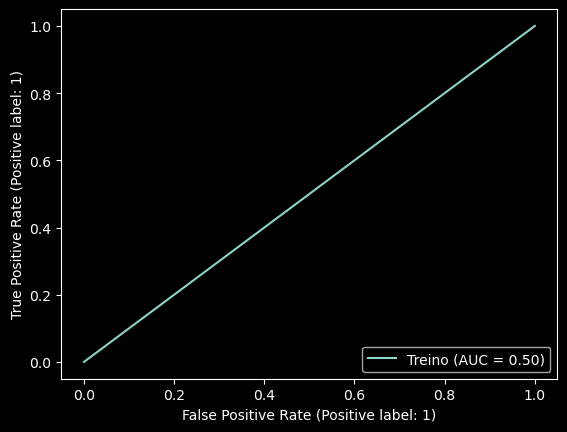

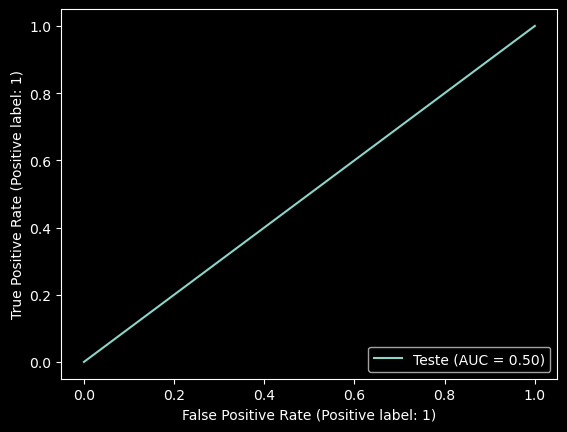

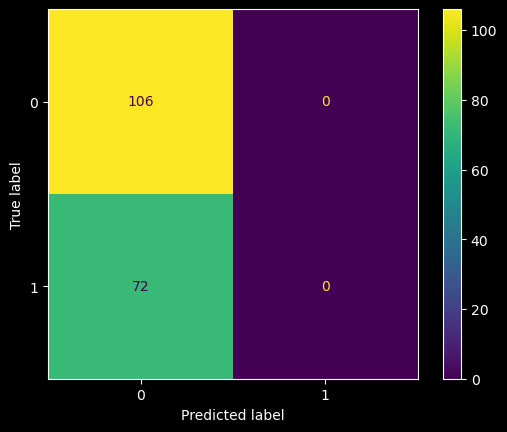

In [8]:
# MODELO BASE
from sklearn.dummy import DummyClassifier
classificador = DummyClassifier()

#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = classificador.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

## Decision Tree

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       318
           1       0.82      0.72      0.76       216

    accuracy                           0.82       534
   macro avg       0.82      0.80      0.81       534
weighted avg       0.82      0.82      0.82       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[283  35]
 [ 61 155]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       106
           1       0.86      0.71      0.78        72

    accuracy                           0.84       178
   macro avg       0.84      0.82      0.82       178
weighted avg       0.84      0.84      0.83       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[98  8]
 [21 51]]
**********************************************************************


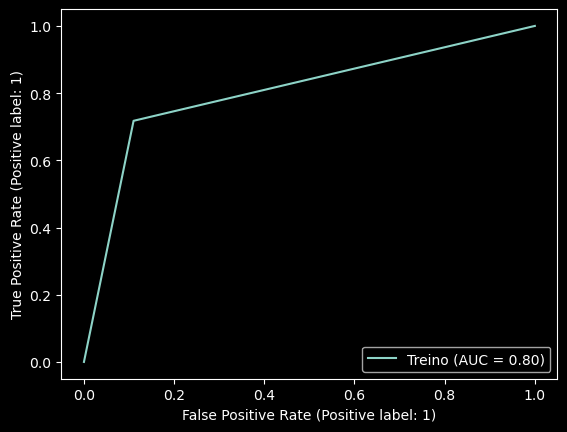

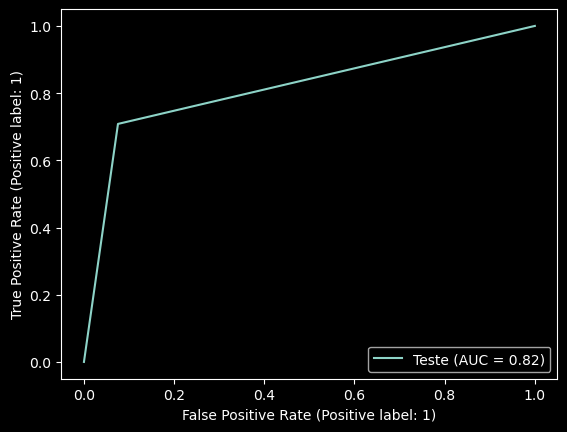

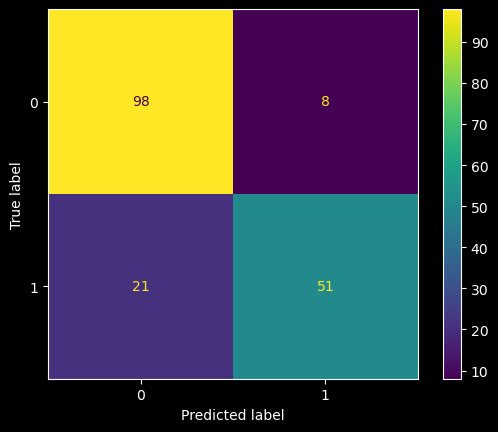

In [9]:
# APLICANDO MODELO
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

classificador = DecisionTreeClassifier(random_state=5, max_depth = 3)
#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = classificador.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

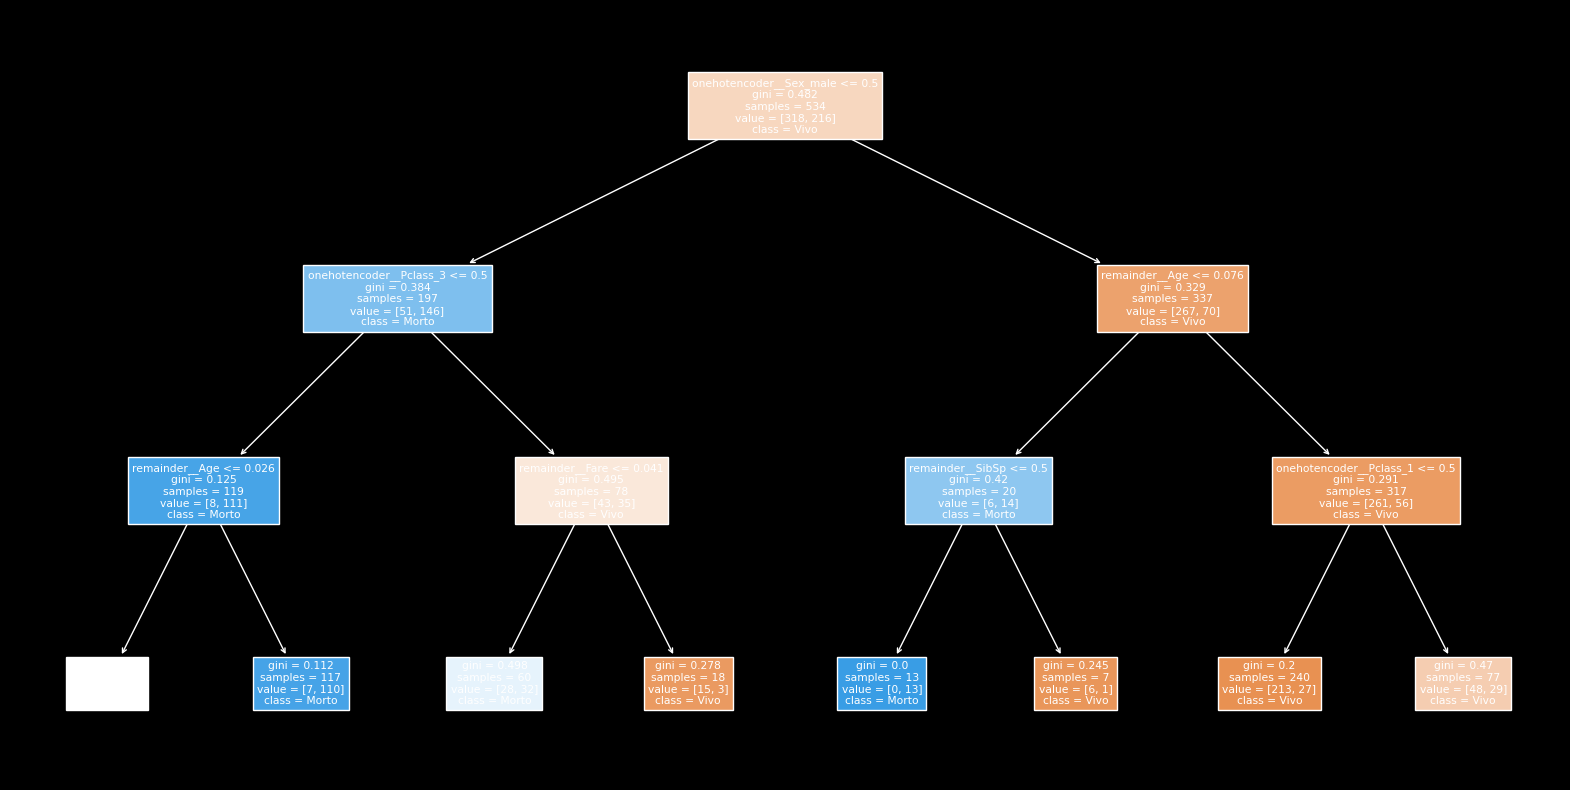

In [10]:
# Visualização da Árvore de Decisão
plt.figure(figsize=(20,10))

plot_tree(classificador, 
          filled = True, #Coloração das caixas do grafico
          class_names = ['Vivo', 'Morto'],
          feature_names=x_columns)

plt.show()

# Feature Importance

Após treinar um modelo decision tree é possivel traçar `Feature Importance` uma importância das características é uma métrica que indica o quão útil ou valiosa cada característica foi na construção do modelo de árvore de decisão. Essa métrica é calculada durante a construção da árvore e resulta da contribuição de cada característica para a pureza dos nós, ou seja, o quanto a característica ajudou a tornar as decisões do modelo mais claras e menos aleatórias.

O cálculo da importância de uma característica geralmente envolve o seguinte:

- **Redução do Impureza:** A importância de uma característica é calculada com base na redução da impureza que ela proporciona. A impureza de um nó na árvore é medida por critérios como Gini ou entropia, que quantificam o quão misturadas estão as classes dentro de um nó. Características que melhor dividem os dados, resultando em nós mais puros, são consideradas mais importantes.

- **Ponderação por Amostras:** A redução de impureza trazida por uma característica é ponderada pelo número de amostras que passam pelo nó. Isso significa que características que influenciam decisões em nós com muitas amostras têm uma importância maior, refletindo sua utilidade em escala mais ampla dentro do modelo.

- **Agregação:** A importância total de uma característica é a soma de todas as reduções de impureza que ela proporciona, ponderadas pelo número de amostras em todos os nós que ela influencia.


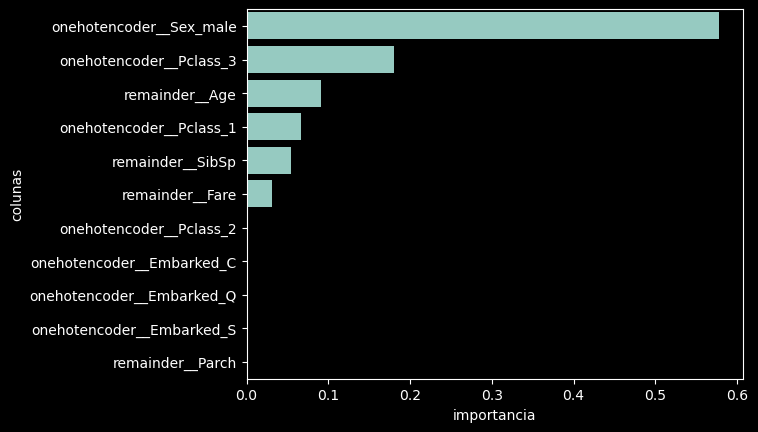

In [11]:
importancias = pd.DataFrame({'colunas': x_columns, 
                            'importancia': classificador.feature_importances_})
importancias = importancias.sort_values(by='importancia', ascending=False)
importancias

import seaborn as sns
sns.barplot(x='importancia',y='colunas', data=importancias);

Porém, surge a pergunta: o ajuste do modelo de Machine Learning se mantém equivalente se eu utilizar apenas as dez features mais importantes? Ou conseguimos automatizar esse processo de escolher as `n` features mais importantes e aplicar direto o Machine Learning? 
É exatamente que é feito na etapa `SelectFromModel`, logo abaixo.

# SelectFromModel - Seleção de Características em Aprendizado de Máquina

`SelectFromModel` é uma técnica de meta-transformação para seleção de características com base na importância das mesmas, conforme determinado por qualquer estimador que atribua pesos às características (como coeficientes em modelos lineares ou importâncias em árvores de decisão).

**Funcionamento do SelectFromModel**

1. **Estimador de Base:**
   - `SelectFromModel` requer um estimador preliminar que seja treinado em dados e que possa atribuir um score de importância a cada característica. Estimadores comuns incluem modelos como Lasso para regressão ou RandomForest para classificação.

2. **Seleção de Características:**
   - Após o treinamento, `SelectFromModel` utiliza os atributos de importância (como coeficientes ou pontuações de importância de características) fornecidos pelo estimador para selecionar características. As características que possuem importâncias acima de um limite especificado são mantidas, enquanto outras são descartadas.

3. **Definição de Limiar:**
   - O limiar para a seleção de características pode ser definido manualmente ou através de um dos métodos automáticos disponíveis, como o uso de `mean`, `median` entre outros critérios baseados na estatística dos scores de importância.

- **Flexibilidade:** Funciona bem com qualquer modelo que atribua importâncias às características, proporcionando uma abordagem versátil para a seleção de características.
- **Automatização:** Pode automaticamente ajustar o limiar de corte para a seleção baseado em diferentes critérios estatísticos, facilitando a otimização do modelo.
- **Escolha do Limiar:** A definição inadequada do limiar pode levar tanto à eliminação de características importantes quanto à retenção de características irrelevantes.

In [12]:
print(x_treino.shape)
print(x_teste.shape)

(534, 11)
(178, 11)


In [13]:
# Imprimido o nome apenas das 3 features mais importantes para o modelo
importancias.head(3)['colunas'].values

array(['onehotencoder__Sex_male', 'onehotencoder__Pclass_3',
       'remainder__Age'], dtype=object)

In [14]:
from sklearn.feature_selection import SelectFromModel
modelo_selecionadas = SelectFromModel(classificador, 
                                      max_features=3, # Selecinando apenas as 3 features mais importantes para o modelo
                                      prefit=True #Indica que o fit do modelo ja foi realizado
                                      )

x_treino_selecionadas = modelo_selecionadas.transform(x_treino)
x_teste_selecionadas = modelo_selecionadas.transform(x_teste)

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       318
           1       0.79      0.70      0.75       216

    accuracy                           0.81       534
   macro avg       0.80      0.79      0.79       534
weighted avg       0.80      0.81      0.80       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[278  40]
 [ 64 152]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       106
           1       0.81      0.71      0.76        72

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[94 12]
 [21 51]]
**********************************************************************


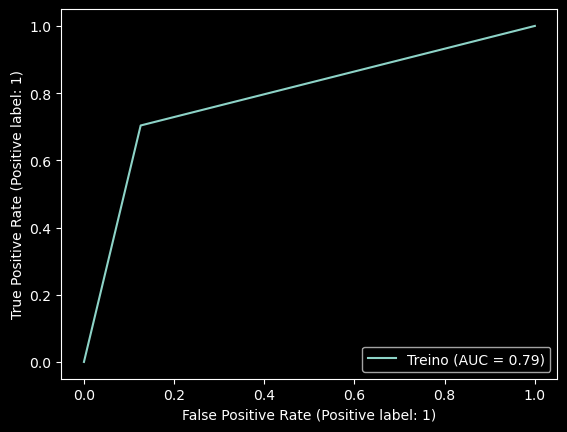

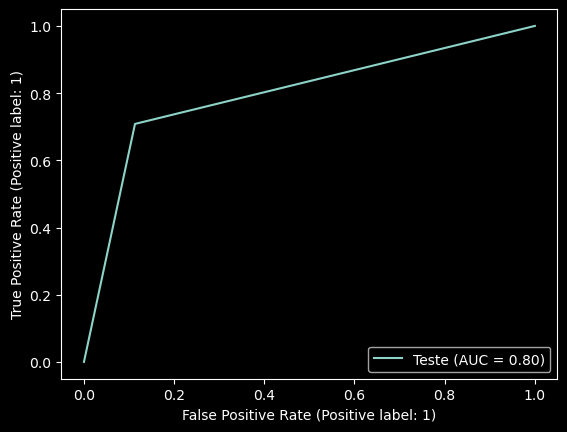

In [48]:
# Instanciando o modelo para que ele comece do zero novamente
classificador_selecionadas = DecisionTreeClassifier(random_state=5, max_depth = 3)
#######################################################################################
# Treinamento do Modelo
classificador_selecionadas.fit(x_treino_selecionadas, y_treino)

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = classificador_selecionadas.predict(x_treino_selecionadas)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador_selecionadas.predict(x_teste_selecionadas)
avaliar_modelo(y_teste, previsoes, "Teste")
#######################################################################################

Estamos acertando uma taxa alta ainda com o modelo de Machine Learning utilizando uma quantidade menor de features.

Isso pode ser bastante útil em casos em que temos um grande conjunto de dados ou ainda, em caso de problemas para coletar certas informações a partir de todos os datasets por questões de dados sensíveis, por exemplo. Nesses casos, podemos optar por manter apenas as features para manter uma performance adequada para o modelo.

# SelectKBest

Um método alternativo para a seleção de features é a função `SelectKBest`. Essa função faz parte do módulo feature_selection da biblioteca Scikit-learn e é utilizada para selecionar as melhores características (variáveis) de um conjunto de dados com base em algum critério de avaliação. O critério mais comum é a pontuação das características em relação a uma variável alvo (supervisionada). A ideia é que, ao selecionar apenas as melhores características, o modelo resultante seja mais eficiente, mais fácil de interpretar e menos propenso a overfitting.

O parâmetro `k` na função `SelectKBest` define o número de melhores características a serem selecionadas. A função avalia todas as características do conjunto de dados e seleciona as `k` características com as pontuações mais altas de acordo com o critério escolhido.

**Vantagens da SelectKBest:**

**Dimensionamento:** A função ajuda a reduzir o dimensionamento do conjunto de dados, tornando-o mais gerenciável, o que é especialmente importante em conjuntos de dados com muitas características.
**Melhora da Performance:** A seleção de características pode melhorar o desempenho do modelo, uma vez que foca nas características mais relevantes, reduzindo o ruído presente em características menos informativas.
**Interpretação:** Modelos resultantes de conjuntos de dados com um número menor de características são mais fáceis de interpretar e visualizar, facilitando a comunicação dos resultados.

**Desvantagens da SelectKBest:**

**Informação Perdida:** A principal desvantagem é que a seleção de características no geral pode levar à perda de informações relevantes, caso algumas características menos pontuadas sejam importantes em contextos específicos.
**Dependência do Critério:** A eficácia da seleção de características depende fortemente do critério de avaliação escolhido. Um critério inadequado pode levar à seleção incorreta de características.
**Rigidez:** Fixar um número `k` de características pode não se adaptar bem a todos os conjuntos de dados. Às vezes, um número diferente de características seria mais apropriado.

Em resumo, a função `SelectKBest` é uma ferramenta útil para selecionar um subconjunto de características relevantes para a construção de modelos. No entanto, é importante pesar as vantagens e desvantagens antes de aplicá-la, considerando o contexto específico do problema, o critério de avaliação escolhido e a necessidade de interpretabilidade do modelo resultante.

# Recursive Feature Elimination (RFE) - Eliminação Recursiva de Características

**Funcionamento do RFE**

1. **Modelo de Base:**
   - RFE requer um modelo de base que possa fornecer algum tipo de importância ou coeficientes para cada característica.

2. **Processo Recursivo:**
   - O algoritmo funciona eliminando recursivamente características. Inicialmente, o modelo é treinado com todas as características disponíveis e a importância de cada característica é obtida, geralmente através de coeficientes ou de outro índice de importância fornecido pelo modelo.

3. **Eliminação:**
   - Em cada etapa, uma ou mais características consideradas as menos importantes são removidas do conjunto de dados.
   - O modelo é então re-treinado com o conjunto de características reduzido, e o processo se repete.

4. **Critério de Parada:**
   - O processo de eliminação continua até que o número desejado de características seja alcançado, ou até que o desempenho do modelo comece a deteriorar significativamente.


**Considerações**

- **Custo Computacional:** Dependendo do número inicial de características e do modelo de base utilizado, RFE pode ser computacionalmente custoso, especialmente em grandes conjuntos de dados.
- **Escolha do Modelo:** A eficácia do RFE depende significativamente do modelo de base escolhido. Modelos que fornecem medidas de importância de características imprecisas ou inadequadas podem levar a uma seleção pobre.

In [16]:
print(x_treino.shape)
print(x_teste.shape)

(534, 11)
(178, 11)


In [17]:
from sklearn.feature_selection import RFE

# Instanciando o modelo para que ele comece do zero novamente
modelo = DecisionTreeClassifier(random_state=5, max_depth = 3)

selecionador = RFE(modelo, 
                   n_features_to_select=3, 
                   step=1
                   )
#O RFE é um método recursivo de remoção de recursos. 
# No bloco acima, definimos que ele vai remover uma 
# feature a cada iteração do algoritmo.

# Treinando selecionador de features
selecionador.fit(x_treino, y_treino)

# Após isso, podemos transformar nossos dados de treino
#  e de teste, mantendo apenas as mesmas colunas das vez 
# melhores features para ambos.
x_treino_selecionadas = selecionador.transform(x_treino)
x_teste_selecionadas = selecionador.transform(x_teste)

# Treinamento do Modelo
modelo.fit(x_treino_selecionadas, y_treino)

DecisionTreeClassifier(max_depth=3, random_state=5)

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       318
           1       0.79      0.70      0.75       216

    accuracy                           0.81       534
   macro avg       0.80      0.79      0.79       534
weighted avg       0.80      0.81      0.80       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[278  40]
 [ 64 152]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       106
           1       0.81      0.71      0.76        72

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[94 12]
 [21 51]]
**********************************************************************


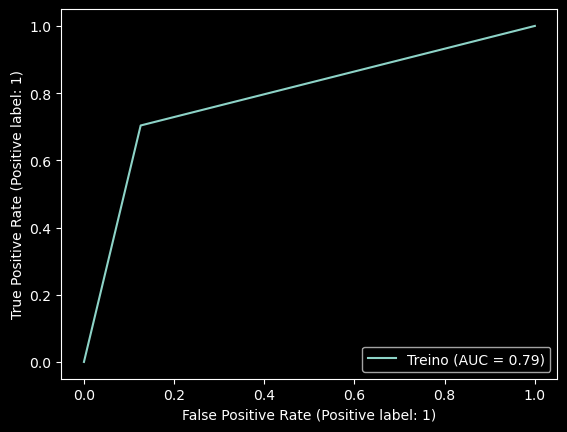

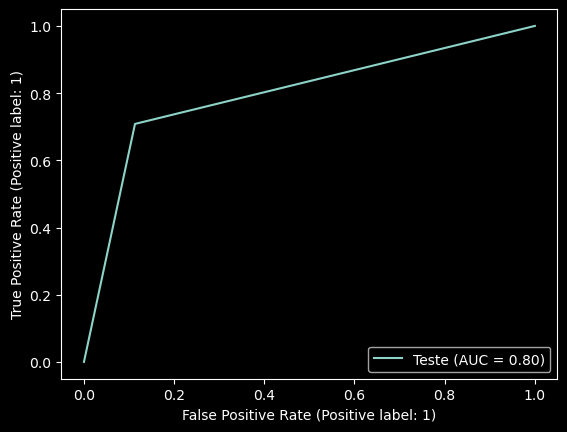

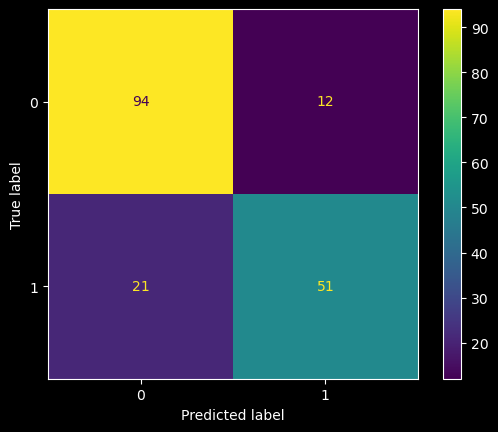

In [18]:
#######################################################################################
# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = modelo.predict(x_treino_selecionadas)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = modelo.predict(x_teste_selecionadas)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

# FIM